In [23]:
import pandas as pd
import tensorflow as tf
from constants import target_name, x_path, y_path, x_test_path, y_test_path, preprocessed_data
from sklearn.preprocessing import MinMaxScaler
from libs.simple_processing import separate_target, split_train_test

df = pd.read_csv(preprocessed_data)

# scaled = df
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled = pd.DataFrame(scaled, columns=df.columns)

length = int(len(scaled) * 0.99)
TEST = scaled[length:]
DATA = scaled[:length]

X, y = separate_target(DATA, target_name)
Xt, yt = separate_target(TEST, target_name)

X.to_csv(x_path, index=False)
y.to_csv(y_path, index=False)
Xt.to_csv(x_test_path, index=False)
yt.to_csv(y_test_path, index=False)


X_train, X_valid, y_train, y_valid = split_train_test(X, y, 0.65)

tf.random.set_seed(7)

X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12077,0.090909,0.21875,0.123774,0.004046,0.2,0.0,0.0,0.50,0.416667,0.179825,0.000000,0.252174,0.0,0.323232,0.595786,0.589701,0.163655,0.009590
13350,0.121212,0.31250,0.215849,0.004093,0.4,0.0,0.0,0.50,0.666667,0.313596,0.000000,0.921739,0.0,0.277778,0.579057,0.263289,0.452762,0.009180
5039,0.090909,0.18750,0.103396,0.004978,0.0,0.0,0.0,0.75,0.500000,0.086623,0.120332,0.513043,0.0,0.005051,0.250603,0.258306,0.189468,0.008977
19685,0.121212,0.43750,0.233962,0.002095,0.4,0.0,0.0,0.50,0.666667,0.254386,0.161826,0.991304,0.0,1.000000,0.791861,0.092193,0.507830,0.004037
19785,0.121212,0.31250,0.160981,0.004102,0.4,0.0,0.0,0.50,0.583333,0.233882,0.000000,0.913043,0.0,0.111111,0.268297,0.123754,0.360695,0.007855


In [47]:
from libs.dl.simple_regressor import SimpleRegressor
import keras_tuner
from libs.simple_processing import separate_target, split_train_test

def build_fit_callback(hp):

    split = hp.Float("mp", min_value=0.5, max_value=0.8, step=0.05)

    X_train, X_valid, y_train, y_valid = split_train_test(X, y, split)

    batch_size = 256

    features_count = X_train.shape[1]
    epochs = 60
    # optimizer = tf.keras.optimizers.Adam()
    # optimizer = tf.keras.optimizers.Adadelta()
    optimizer = "adam" #hp.Choice('optimizer', ['adam', 'sgd'])
    # activation = tf.keras.activations.sigmoid()
    # activation = tf.keras.activations.relu
    activation = "relu"#hp.Choice('activation', ['relu', 'sigmoid'])
    mp = 4 #hp.Int("mp", min_value=2, max_value=6, step=2)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(features_count, activation=activation, input_shape=[features_count]))
    model.add(tf.keras.layers.Dense(features_count * mp, activation=activation))
    model.add(tf.keras.layers.Dense(features_count * mp, activation=activation))
    model.add(tf.keras.layers.Dense(features_count * mp *2, activation=activation))
    model.add(tf.keras.layers.Dense(features_count * mp, activation=activation))
    model.add(tf.keras.layers.Dense(features_count * mp, activation=activation))
    model.add(tf.keras.layers.Dense(features_count, activation=activation))
    model.add(tf.keras.layers.Dense(1))

    model.compile(
        optimizer=optimizer,
        loss="mean_absolute_error",
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    model.fit(x=X_train, y=y_train,
                             validation_data=(X_valid, y_valid)
                             , batch_size=batch_size
                             , epochs=epochs
                             # , callbacks=[early_stopping]
                             # , use_multiprocessing=True
                             , verbose='2'
                             # , callbacks=[tensorboard_callback]
                             )

    return model

tuner = keras_tuner.Hyperband(
    hypermodel=build_fit_callback,
    objective=keras_tuner.Objective("val_mean_absolute_error", direction="min"),
    max_epochs=50,
    factor=3,
    seed=42,
    overwrite=True,
    directory="logs/keras_tuner"
)
tuner.search(
    x=X_train,
    y=y_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_valid, y_valid)
)
tuner.results_summary()


Trial 6 Complete [00h 00m 29s]
val_mean_absolute_error: 0.009690742008388042

Best val_mean_absolute_error So Far: 0.009145285002887249
Total elapsed time: 00h 03m 10s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
0.8               |0.65              |mp
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round



Traceback (most recent call last):
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/var/folders/r3/hdngxsmd2vq391vqv6kg6f7w0000gq/T/ipykernel_73860/3099039305.py", line 9, in build_fit_callback
    X_train, X_valid, y_train, y_valid = split_train_test(X, y, split)
  File "/Users/kkepins-macwro_1/Library/Mobile Documents/com~apple~CloudDocs/_GIT/data-science-upskills/deep-learning/house-prices/libs/simple_processing.py", line 40, in split_train_test
    return train_test_split(x_train, y_train, train_size=train_size, test_size=test_size,
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-u

Invalid model 0/5


Traceback (most recent call last):
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/var/folders/r3/hdngxsmd2vq391vqv6kg6f7w0000gq/T/ipykernel_73860/3099039305.py", line 9, in build_fit_callback
    X_train, X_valid, y_train, y_valid = split_train_test(X, y, split)
  File "/Users/kkepins-macwro_1/Library/Mobile Documents/com~apple~CloudDocs/_GIT/data-science-upskills/deep-learning/house-prices/libs/simple_processing.py", line 40, in split_train_test
    return train_test_split(x_train, y_train, train_size=train_size, test_size=test_size,
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-u

Invalid model 1/5
Invalid model 2/5
Invalid model 3/5


Traceback (most recent call last):
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 158, in _try_build
    model = self._build_hypermodel(hp)
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-upskills-eseJr18D/lib/python3.10/site-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/var/folders/r3/hdngxsmd2vq391vqv6kg6f7w0000gq/T/ipykernel_73860/3099039305.py", line 9, in build_fit_callback
    X_train, X_valid, y_train, y_valid = split_train_test(X, y, split)
  File "/Users/kkepins-macwro_1/Library/Mobile Documents/com~apple~CloudDocs/_GIT/data-science-upskills/deep-learning/house-prices/libs/simple_processing.py", line 40, in split_train_test
    return train_test_split(x_train, y_train, train_size=train_size, test_size=test_size,
  File "/Users/kkepins-macwro_1/.local/share/virtualenvs/data-science-u

Invalid model 4/5
Invalid model 5/5


RuntimeError: Too many failed attempts to build model.

In [48]:
winner_params = tuner.get_best_hyperparameters(1)

print("\nWinner Params:\n")
print(winner_params)

winner = tuner.get_best_models()

print("\nWinner Model:\n")
print(winner.evaluate())


Winner Params:

Epoch 1/60


2023-01-13 16:13:27.140760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/60


2023-01-13 16:13:28.265761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60

Winner Model:



In [24]:
from libs.simple_plotter import plot_history

features_count = X_train.shape[1]
batch_size = 64
epochs = 100
optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.Adamax()
# activation = tf.keras.activations.sigmoid()
activation = tf.keras.activations.relu
mp = 5 #hp.Int("mp", min_value=2, max_value=6, step=2)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(features_count, activation=activation, input_shape=[features_count]))
model.add(tf.keras.layers.Dense(features_count * mp, activation=activation))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(features_count * mp, activation=activation))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(features_count * mp *2, activation=activation))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(features_count * mp *4, activation=activation))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(features_count * mp *2, activation=activation))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(features_count * mp, activation=activation))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(features_count * mp, activation=activation))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(features_count, activation=activation))
model.add(tf.keras.layers.Dense(1))

model.compile(
    optimizer=optimizer,
    loss="mean_absolute_error",
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

history_df = model.fit(x=X_train, y=y_train
          , validation_data=(X_valid, y_valid)
          , batch_size=batch_size
          , epochs=epochs
          # , callbacks=[early_stopping]
          # , use_multiprocessing=True
          , verbose='2'
          # , callbacks=[tensorboard_callback]
          )

score2 = model.evaluate(X_valid, y_valid, verbose=1)
print("Evaluation Score: ", score2)


Epoch 1/100


2023-01-13 17:17:56.210471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-13 17:17:59.441684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

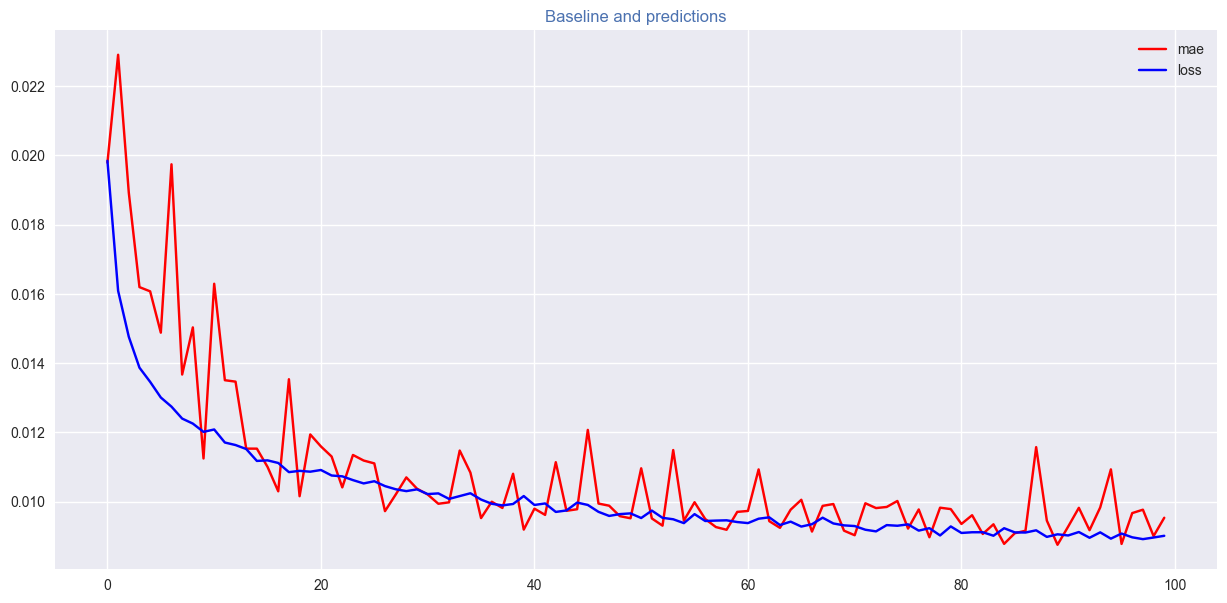

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, imp
imp.reload(sys.modules['libs.simple_plotter'])
from libs.simple_plotter import plot_keras_model_history

mae = history_df.history['val_mean_absolute_error']
loss = history_df.history['loss']

plot_keras_model_history(mae, loss, "mae", "loss")


7/7 [==============================] - 0s 11ms/step


2023-01-13 17:23:14.995827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test Data MAE:  0.011458541850970252
Test Data MAE % : 0.14347737987529027


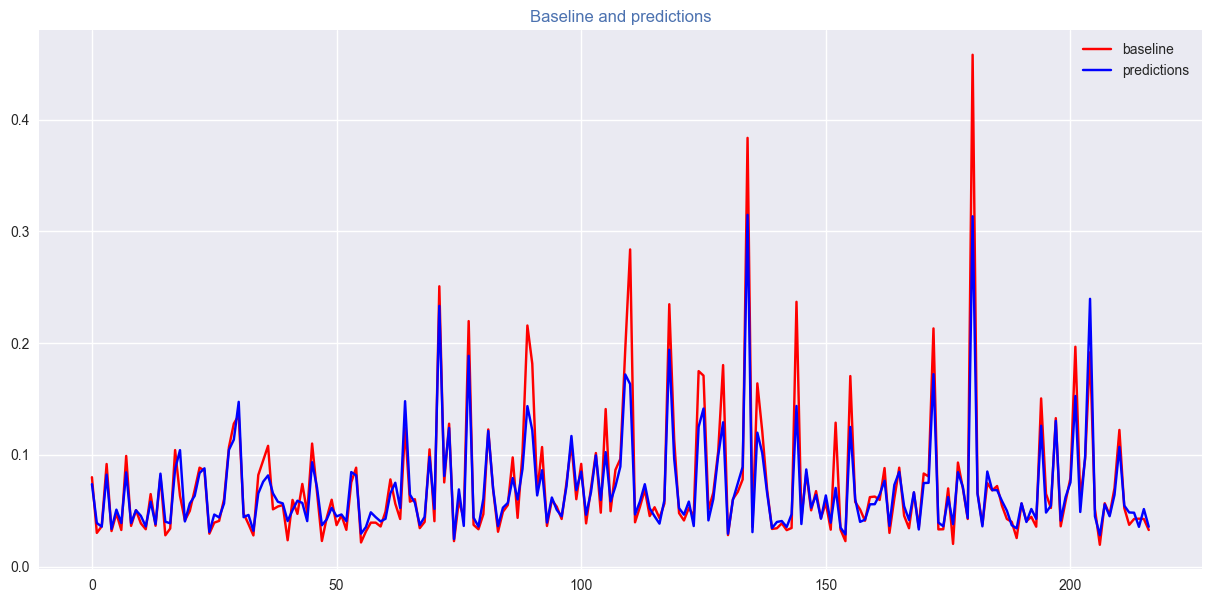

In [26]:
import sklearn as skl
from libs.simple_plotter import plot_keras_model_history

# score = model.evaluate(X_valid, y_valid, verbose=0)
# print("Loss: {:0.5f}".format(score))

pred = model.predict(Xt)

# uyt = scaler.inverse_transform(yt)
# upred = scaler.inverse_transform(pred)

print('Test Data MAE: ', skl.metrics.mean_absolute_error(yt, pred))
print('Test Data MAE % :', skl.metrics.mean_absolute_percentage_error(yt, pred))

plot_keras_model_history(yt, pred, "baseline", "predictions")
